# <img src="https://img.icons8.com/dusk/64/000000/code.png" style="height:50px;display:inline"> Soft-IntroVAE Code Tutorial - 2D Datasets
---

Tal Daniel


<center>
    <a href="https://colab.research.google.com/github/taldatech/soft-intro-vae-pytorch/blob/main/soft_intro_vae_tutorial/soft_intro_vae_2d_code_tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</center>

* Paper: [**Soft-IntroVAE: Analyzing and Improving the Introspective Variational Autoencoder**, Tal Daniel and Aviv Tamar](https://arxiv.org/abs/2012.13253)
* GitHub: <a href="https://github.com/taldatech/soft-intro-vae-pytorch">soft-intro-vae-pytorch</a>

### <img src="https://img.icons8.com/color/96/000000/loading.png" style="height:50px;display:inline"> Running Instructions
---
* This Jupyter Notebook can be opened locally with Anaconda, or online via Google Colab.
* To run online, go to https://colab.research.google.com/ and drag-and-drop the `soft_intro_vae_2d_code_tutorial.ipynb` file.
    * On Colab, note the "directory" icon on the left, figures and checkpoints are saved in this directory.
* To run the training on the image dataset, it is better to have a GPU. In Google Cola select `Runtime->Change runtime type->GPU`.

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Variational Autoencoders (VAEs)](#-Variational-Autoencoders-(VAEs))
* [Soft-IntroVAE Objectives](#-Soft-IntroVAE-Objectives)
* [2D Inference and Sampling Experiments](#-2D-Inference-and-Sampling-Experiments)
    * [2D Experiments - Datsets and Architectures](#2D-Experiments---Datsets-and-Architectures)
    * [2D Experiments - Algorithm and Train Function](#2D-Experiments---Algorithm-and-Train-Function)
* [More Tutorials](#-But-Wait,-There-is-More...)
* [Credits](#-Credits)

### <img src="https://img.icons8.com/plasticine/100/000000/epsilon.png" style="height:50px;display:inline"> Variational Autoencoders (VAEs)
---
Unlike regular autoencoders, Variational Autoencoder (VAE, <a href="https://arxiv.org/abs/1312.6114">Kingma & Welling, 2014</a>) map the input to a distribution.

In VAE we infer $p_{\theta}(z|X)$ using a method calld **Variational Inference (VI)** (hence the name **Variational** Autoencoder).

**Variational Inference (VI)** - solve an optimization problem in which we model $p_{\theta}(z|X)$ using a simpler distribution, $q_{\phi}(z|x)$, which is easier to evaluate, like a Gaussian, and **minimize the difference between these distributions using the KL-divergence**.

**Evidence Lower BOund (ELBO)** - the optimization problem is to make the simpler distribution, $q_{\phi}(z|X)$ as closer as possible to $p_{\theta}(z|X)$. Using the KL-divergence, the we get the evidence lower bound: $$ \log p_{\theta}(X) \geq \mathbb{E}_{q_{\phi}(z|X)}[\log p_{\theta}(X|z)] - D_{KL}[q_{\phi}(z|X) || p(z)] = ELBO(X; \theta, \phi).$$

$p(z)$ is a prior, independent of the model. In VAE, a common choice for the prior is a simple one $$p(z) \sim \mathcal{N}(0,1).$$

$q_{\phi}(z|X)$ is also called the **encoder** and $p_{\theta}(X|z)$ the **decoder**.

In practice, the ELBO is decomposed to the **reconstruction error** and the KL-divergence, which has a closed-form solution in the Gaussian case.

The optimization is made possible thanks to the **reparameterization trick**, as it allows to backpropagate the gradients through the stochastic latent variable: $$ z \sim q_{\phi}(z|X) = \mathcal{N}(z; \mu, \sigma^2 I) $$ $$ \to z = \mu + \sigma \odot \epsilon, \text{where } \epsilon \sim \mathcal{N}(0, I) $$

<img src="https://raw.githubusercontent.com/taldatech/soft-intro-vae-web/main/assets/vae_lilian_weng_lilianweng.github.io.png" style="height:300px">

* <a href="https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#beta-vae">Image by Lilian Weng</a>

### <img src="https://img.icons8.com/fluent/96/000000/rubiks-cube.png" style="height:50px;display:inline"> Soft-IntroVAE Objectives
---
In Soft-IntroVAE, the encoder and decoder are trained to maximize the ELBO for real data (as in standard VAEs), and in addition, we use the exponential of the ELBO (expELBO) to "push away" fake data, generated by the decoder, from the latent space learned by the encoder, while the decoder also tries to pull back its generated data closer to the latent space, hence improving over time.

Comparing to GANs, the discriminatory signal comes from the encoder (the ELBO acts as an energy function), thus, the VAE is trained in an introspective manner (no need for an additional discriminator).

The objective of Soft-IntroVAE is written as follows:

$$ \mathcal{L}_{E_{\phi}}(x,z) = s \cdot(\beta_{rec}\mathcal{L}_r(x) +\beta_{kl}KL(x)) + \frac{1}{2}\exp(-2s\cdot (\beta_{rec}\mathcal{L}_r(D_{\theta}(z)) + \beta_{neg}KL(D_{\theta}(z)))), $$
$$ \mathcal{L}_{D_{\theta}}(x,z) = s \cdot \beta_{rec}\mathcal{L}_r(x) +s \cdot(\beta_{kl}KL(D_{\theta}(z)) +\gamma_r \cdot \beta_{rec}\mathcal{L}_r(D_{\theta}(z))), $$

where $\mathcal{L}_r(x) = - \mathbb{E}_{q_{\phi}(z\mid x)}\left[\log p_{\theta}(x \mid z)\right]$ denotes the reconstruction error, $s$ is a scaling constant which is set to the inverse of the input dimensions, and $\beta_{rec}, \beta_{kl}, \beta_{neg}$ and $\gamma_r$ are hyperparameters. 

Note that in all our experiments the "coeffecient of fake data reconstruction error", $\gamma_r = 1e-8$ (in the bootstrap version in can be set to 1), as setting it to higher values may hold back the decoder and slow down convergence (since at the beginning, the generated data is really bad). Basically, this hyperparamter can be annealed to 1 over time, but for simplicity, we don't do it.

<img src="https://raw.githubusercontent.com/taldatech/soft-intro-vae-web/main/assets/sintrovae_flow.PNG" style="height:350px">

In [1]:
# imports for the tutorial
import os
import time
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

## <img src="https://img.icons8.com/bubbles/50/000000/average-value.png" style="height:50px;display:inline"> 2D Inference and Sampling Experiments
---
In this part, we will demonstrate Soft-IntroVAE on 2D distributions datasets. We begin with defining the datasets and architectures. You can skip this part and move straight to the training and results.

### <img src="https://img.icons8.com/dusk/64/000000/venn-diagram.png" style="height:50px;display:inline">2D Experiments - Datsets and Architectures
---
This part defines the building blocks of the Soft-IntroVAE and the 2D datsets.

In [2]:
"""
2D Datasets
"""
class ToyDataset:
    def __init__(self, distr='8Gaussians', dim=2, scale=2, iter_per_mode=100):
        self.distr = distr
        self.dim = dim
        self.scale = scale

        self.dataset = []
        for i in range(100000 // 25):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = np.random.randn(2) * 0.05
                    point[0] += 2 * x
                    point[1] += 2 * y
                    self.dataset.append(point)
        self.dataset = np.array(self.dataset, dtype='float32')
        np.random.shuffle(self.dataset)
        self.dataset /= 2.828  # stdev

        self.range = 1
        if self.distr == '25Gaussians':
            self.range = 2

        self.curr_iter = 0
        self.curr_mode = 0
        self.iter_per_mode = iter_per_mode

    def next_batch(self, batch_size=64, device=None, sig=0.02):
        dist_1 = ['2spirals', 'checkerboard', 'rings']
        if self.distr in dist_1:
            return sample_2d_data(self.distr, batch_size).to(device)
        else:
            if self.distr == '8Gaussians':
                centers = [
                    (1, 0),
                    (-1, 0),
                    (0, 1),
                    (0, -1),
                    (1. / np.sqrt(2), 1. / np.sqrt(2)),
                    (1. / np.sqrt(2), -1. / np.sqrt(2)),
                    (-1. / np.sqrt(2), 1. / np.sqrt(2)),
                    (-1. / np.sqrt(2), -1. / np.sqrt(2))
                ]
                centers = [(self.scale * x, self.scale * y) for x, y in centers]
                dataset = []
                for i in range(batch_size):
                    point = np.random.randn(2) * sig
                    center = random.choice(centers)
                    point[0] += center[0]
                    point[1] += center[1]
                    dataset.append(point)
                dataset = np.array(dataset, dtype='float32')
                dataset /= 1.414  # stdev

                return torch.FloatTensor(dataset).to(device)

            if self.distr == '25Gaussians':
                batch_idx = np.random.randint(100000 // batch_size)
                return torch.FloatTensor(self.dataset[batch_idx * batch_size:(batch_idx + 1) * batch_size]).to(
                    device) * self.scale

            if self.distr == 'Sequential8Gaussians':
                centers = [
                    (1, 0),
                    (-1, 0),
                    (0, 1),
                    (0, -1),
                    (1. / np.sqrt(2), 1. / np.sqrt(2)),
                    (1. / np.sqrt(2), -1. / np.sqrt(2)),
                    (-1. / np.sqrt(2), 1. / np.sqrt(2)),
                    (-1. / np.sqrt(2), -1. / np.sqrt(2))
                ]
                centers = [(self.scale * x, self.scale * y) for x, y in centers]
                dataset = []
                for i in range(batch_size):
                    point = np.random.randn(2) * .02
                    center = centers[self.curr_mode]  # random.choice(centers)
                    point[0] += center[0]
                    point[1] += center[1]
                    dataset.append(point)
                dataset = np.array(dataset, dtype='float32')
                dataset /= 1.414  # stdev
                if self.curr_iter % self.iter_per_mode == self.iter_per_mode - 1:
                    self.curr_mode += 1
                    self.curr_mode %= 8
                self.curr_iter += 1

                return torch.FloatTensor(dataset).to(device)


def sample_2d_data(dataset, n_samples):
    """
    https://github.com/kamenbliznashki/normalizing_flows/blob/master/bnaf.py
    :param dataset:
    :param n_samples:
    :return:
    """
    z = torch.randn(n_samples, 2)

    if dataset == '8gaussians':
        scale = 4
        sq2 = 1 / np.sqrt(2)
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (sq2, sq2), (-sq2, sq2), (sq2, -sq2), (-sq2, -sq2)]
        centers = torch.tensor([(scale * x, scale * y) for x, y in centers])
        return sq2 * (0.5 * z + centers[torch.randint(len(centers), size=(n_samples,))])

    elif dataset == '2spirals':
        n = torch.sqrt(torch.rand(n_samples // 2)) * 540 * (2 * np.pi) / 360
        d1x = - torch.cos(n) * n + torch.rand(n_samples // 2) * 0.5
        d1y = torch.sin(n) * n + torch.rand(n_samples // 2) * 0.5
        x = torch.cat([torch.stack([d1x, d1y], dim=1),
                       torch.stack([-d1x, -d1y], dim=1)], dim=0) / 3
        return x + 0.1 * z

    elif dataset == 'checkerboard':
        x1 = torch.rand(n_samples) * 4 - 2
        x2_ = torch.rand(n_samples) - torch.randint(0, 2, (n_samples,), dtype=torch.float) * 2
        x2 = x2_ + x1.floor() % 2
        return torch.stack([x1, x2], dim=1) * 2

    elif dataset == 'rings':
        n_samples4 = n_samples3 = n_samples2 = n_samples // 4
        n_samples1 = n_samples - n_samples4 - n_samples3 - n_samples2

        # so as not to have the first point = last point, set endpoint=False in np; here shifted by one
        linspace4 = torch.linspace(0, 2 * np.pi, n_samples4 + 1)[:-1]
        linspace3 = torch.linspace(0, 2 * np.pi, n_samples3 + 1)[:-1]
        linspace2 = torch.linspace(0, 2 * np.pi, n_samples2 + 1)[:-1]
        linspace1 = torch.linspace(0, 2 * np.pi, n_samples1 + 1)[:-1]

        circ4_x = torch.cos(linspace4)
        circ4_y = torch.sin(linspace4)
        circ3_x = torch.cos(linspace4) * 0.75
        circ3_y = torch.sin(linspace3) * 0.75
        circ2_x = torch.cos(linspace2) * 0.5
        circ2_y = torch.sin(linspace2) * 0.5
        circ1_x = torch.cos(linspace1) * 0.25
        circ1_y = torch.sin(linspace1) * 0.25

        x = torch.stack([torch.cat([circ4_x, circ3_x, circ2_x, circ1_x]),
                         torch.cat([circ4_y, circ3_y, circ2_y, circ1_y])], dim=1) * 3.0

        # random sample
        x = x[torch.randint(0, n_samples, size=(n_samples,))]

        # Add noise
        return x + torch.normal(mean=torch.zeros_like(x), std=0.08 * torch.ones_like(x))

    else:
        raise RuntimeError('Invalid `dataset` to sample from.')

In [3]:
"""
Helper Functions
"""
def reparameterize(mu, logvar):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variaance of x
    :return z: the sampled latent variable
    """
    device = mu.device
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std

def load_model(model, pretrained):
    weights = torch.load(pretrained)
    pretrained_dict = weights['model']
    model.load_state_dict(pretrained_dict)
    model_dict = model.state_dict()
    

def save_checkpoint(model, epoch, iteration, prefix=""):
    model_out_path = "./saves/" + prefix + "model_epoch_{}_iter_{}.pth".format(epoch, iteration)
    state = {"epoch": epoch, "model": model.state_dict()}
    if not os.path.exists("./saves/"):
        os.makedirs("./saves/")

    torch.save(state, model_out_path)

    print("model checkpoint saved @ {}".format(model_out_path))


def setup_grid(range_lim=4, n_pts=1000, device=torch.device("cpu")):
    x = torch.linspace(-range_lim, range_lim, n_pts)
    xx, yy = torch.meshgrid((x, x))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
    return xx, yy, zz.to(device)


def format_ax(ax, range_lim):
    ax.set_xlim(-range_lim, range_lim)
    ax.set_ylim(-range_lim, range_lim)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
    
    
def plot_vae_density(model, ax, test_grid, n_pts, batch_size, colorbar=False, beta_kl=1.0,
                     beta_recon=1.0, set_title=True, device=torch.device('cpu')):
    """ plots square grid and vae density """
    model.eval()
    xx, yy, zz = test_grid
    # compute posterior approx density
    # p(x) = E_{z~p(z)}[q(z|x)]
    zzk = []
    with torch.no_grad():
        for zz_i in zz.split(batch_size, dim=0):
                zz_i = zz_i.to(device)
                mu, logvar, _, rec = model(zz_i, deterministic=True)
                recon_error = calc_reconstruction_loss(zz_i, rec, loss_type='mse', reduction='none')
                while len(recon_error.shape) > 1:
                    recon_error = recon_error.sum(-1)
                kl = calc_kl(logvar=logvar, mu=mu, reduce="none")
                zzk_i = -1.0 * (beta_kl * kl + beta_recon * recon_error)
                zzk += [zzk_i.exp()]
    p_x = torch.cat(zzk, 0)
    # plot
    cmesh = ax.pcolormesh(xx.data.cpu().numpy(), yy.data.cpu().numpy(), p_x.view(n_pts, n_pts).data.cpu().numpy(),
                          cmap=plt.cm.jet)
    ax.set_facecolor(plt.cm.jet(0.))
    if set_title:
        ax.set_title('VAE density')
    if colorbar:
        plt.colorbar(cmesh)
        
        
def calc_reconstruction_loss(x, recon_x, loss_type='mse', reduction='sum'):
    """

    :param x: original inputs
    :param recon_x:  reconstruction of the VAE's input
    :param loss_type: "mse", "l1", "bce", "gaussian"
    :param reduction: "sum", "mean", "none"
    :return: recon_loss
    """
    recon_x = recon_x.view(x.size(0), -1)
    x = x.view(x.size(0), -1)
    if reduction not in ['sum', 'mean', 'none']:
        raise NotImplementedError
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='none')
        recon_error = recon_error.sum(1)
        if reduction == 'sum':
            recon_error = recon_error.sum()
        elif reduction == 'mean':
            recon_error = recon_error.mean()
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction=reduction)
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction=reduction)
    else:
        raise NotImplementedError
    return recon_error


def calc_kl(logvar, mu, mu_o=10, is_outlier=False, reduce='sum'):
    """
    Calculate kl-divergence
    :param logvar: log-variance from the encoder
    :param mu: mean from the encoder
    :param mu_o: negative mean for outliers (hyper-parameter)
    :param is_outlier: if True, calculates with mu_neg
    :param reduce: type of reduce: 'sum', 'none'
    :return: kld
    """
    if is_outlier:
        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp() + 2 * mu * mu_o - mu_o.pow(2)).sum(1)
    else:
        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(1)
    if reduce == 'sum':
        kl = torch.sum(kl)
    elif reduce == 'mean':
        kl = torch.mean(kl)
    return kl


def plot_samples_density(dataset, model, scale, device):
    """
    Plot real data from dataset, generated samples from model and density estimation
    """
    model.eval()
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 3, 1)
    plot_batch = dataset.next_batch(batch_size=1024, device=device)
    plot_batch = plot_batch.data.cpu().numpy()
    ax1.scatter(plot_batch[:, 0], plot_batch[:, 1], s=8, label="true dist")
    ax1.set_xlim((-scale * 2, scale * 2))
    ax1.set_ylim((-scale * 2, scale * 2))
    ax1.set_axis_off()
    ax1.set_title('Real Data')
     
    ax2 = fig.add_subplot(1, 3, 2)
    noise_batch = torch.randn(size=(1024, model.zdim)).to(device)
    plot_fake_batch = model.sample(noise_batch)
    plot_fake_batch = plot_fake_batch.data.cpu().numpy()
    ax2.scatter(plot_fake_batch[:, 0], plot_fake_batch[:, 1], s=8, c='g', label="fake")
    ax2.set_xlim((-scale * 2, scale * 2))
    ax2.set_ylim((-scale * 2, scale * 2))
    ax2.set_axis_off()
    ax2.set_title('Fake Samples')
    
    ax3 = fig.add_subplot(1, 3, 3)
    test_grid = setup_grid(range_lim=scale * 2, n_pts=1024, device=torch.device('cpu'))
    plot_vae_density(model, ax3, test_grid, n_pts=1024, batch_size=256, colorbar=False,
                     beta_kl=1.0, beta_recon=1.0, set_title=False, device=device)
    ax3.set_axis_off()
    ax3.set_title("Density Estimation")
    return fig

In [4]:
"""
Models
"""

class EncoderSimple(nn.Module):
    def __init__(self, x_dim=2, zdim=2, n_layers=2, num_hidden=64):
        super(EncoderSimple, self).__init__()

        self.xdim = x_dim
        self.zdim = zdim
        self.n_layer = n_layers
        self.num_hidden = num_hidden
        self.main = nn.Sequential()
        self.main.add_module('input', nn.Linear(x_dim, num_hidden))
        self.main.add_module('act0', nn.ReLU(True))
        for i in range(n_layers):
            self.main.add_module('hidden_%d' % (i + 1), nn.Linear(num_hidden, num_hidden))
            self.main.add_module('act_%d' % (i + 1), nn.ReLU(True))
        self.main.add_module('output', nn.Linear(num_hidden, zdim * 2))

    def forward(self, x):
        y = self.main(x).view(x.size(0), -1)
        mu, logvar = y.chunk(2, dim=1)
        return mu, logvar


class DecoderSimple(nn.Module):
    def __init__(self, x_dim=2, zdim=2, n_layers=2, num_hidden=64):
        super(DecoderSimple, self).__init__()

        self.xdim = x_dim
        self.zdim = zdim
        self.n_layer = n_layers
        self.num_hidden = num_hidden
        self.loggamma = nn.Parameter(torch.tensor(0.0))
        self.main = nn.Sequential()

        self.main.add_module('input', nn.Linear(zdim, num_hidden))
        self.main.add_module('act0', nn.ReLU(True))
        for i in range(n_layers):
            self.main.add_module('hidden_%d' % (i + 1), nn.Linear(num_hidden, num_hidden))
            self.main.add_module('act_%d' % (i + 1), nn.ReLU(True))
        self.main.add_module('output', nn.Linear(num_hidden, x_dim))

    def forward(self, z):
        z = z.view(z.size(0), -1)
        return self.main(z)


class SoftIntroVAESimple(nn.Module):
    def __init__(self, x_dim=2, zdim=2, n_layers=2, num_hidden=64):
        super(SoftIntroVAESimple, self).__init__()

        self.xdim = x_dim
        self.zdim = zdim
        self.n_layer = n_layers
        self.num_hidden = num_hidden

        self.encoder = EncoderSimple(x_dim, zdim, n_layers, num_hidden)

        self.decoder = DecoderSimple(x_dim, zdim, n_layers, num_hidden)

    def forward(self, x, deterministic=False):
        mu, logvar = self.encode(x)
        if deterministic:
            z = mu
        else:
            z = reparameterize(mu, logvar)
        y = self.decode(z)
        return mu, logvar, z, y

    def sample(self, z):
        y = self.decode(z)
        return y

    def sample_with_noise(self, num_samples=1, device=torch.device("cpu")):
        z = torch.randn(num_samples, self.zdim).to(device)
        return self.decode(z)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def decode(self, z):
        y = self.decoder(z)
        return y

### <img src="https://img.icons8.com/bubbles/50/000000/loading-bar.png" style="height:50px;display:inline">2D Experiments - Algorithm and Train Function
---
This part defines the training algorithm of Soft-IntroVAE.

In [5]:
def train_soft_intro_vae_toy(z_dim=2, lr_e=2e-4, lr_d=2e-4, batch_size=32, n_iter=30000, num_vae=0, 
                             save_interval=1, recon_loss_type="mse", beta_kl=1.0, beta_rec=1.0,
                             beta_neg=1.0, test_iter=5000, seed=-1, pretrained=None, scale=1,
                             device=torch.device("cpu"), dataset="8Gaussians", gamma_r=1e-8):
    if seed != -1:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        print("random seed: ", seed)

    # --------------build models -------------------------
    train_set = ToyDataset(distr=dataset)
    scale *= train_set.range  # the scale of the 2d grid ([-1, 1] for Gaussians, [-2, 2] for the rest)

    model = SoftIntroVAESimple(x_dim=2, zdim=z_dim, n_layers=3, num_hidden=256).to(device)
    if pretrained is not None:
        load_model(model, pretrained)
    print(model)

    optimizer_e = optim.Adam(model.encoder.parameters(), lr=lr_e)
    optimizer_d = optim.Adam(model.decoder.parameters(), lr=lr_d)

    milestones = (10000, 15000)
    e_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_e, milestones=milestones, gamma=0.1)
    d_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_d, milestones=milestones, gamma=0.1)

    start_time = time.time()
    dim_scale = 0.5  # normalizing factor, 's' in the paper

    for it in range(n_iter):
        batch = train_set.next_batch(batch_size=batch_size, device=device)
        # save models
        if it % save_interval == 0 and it > 0:
            save_epoch = (it // save_interval) * save_interval
            save_checkpoint(model, save_epoch, it, '')

        model.train()
        # --------------train----------------
        if it < num_vae:
            # vanilla VAE training, optimizeing the ELBO for both encoder and decoder
            batch_size = batch.size(0)

            real_batch = batch.to(device)

            # =========== Update E, D ================
            real_mu, real_logvar, z, rec = model(real_batch)

            loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")
            loss_kl = calc_kl(real_logvar, real_mu, reduce="mean")
            loss = beta_rec * loss_rec + beta_kl * loss_kl

            optimizer_e.zero_grad()
            optimizer_d.zero_grad()
            loss.backward()
            optimizer_e.step()
            optimizer_d.step()

            if it % test_iter == 0:
                info = "\nIter: {}/{} : time: {:4.4f}: ".format(it, n_iter, time.time() - start_time)
                info += 'Rec: {:.4f}, KL: {:.4f} '.format(loss_rec.data.cpu(), loss_kl.data.cpu())
                print(info)
        else:
            # soft-intro-vae training
            if len(batch.size()) == 3:
                batch = batch.unsqueeze(0)

            b_size = batch.size(0)

            # generate random noise to produce 'fake' later
            noise_batch = torch.randn(size=(b_size, z_dim)).to(device)
            real_batch = batch.to(device)

            # =========== Update E ================
            for param in model.encoder.parameters():
                param.requires_grad = True
            for param in model.decoder.parameters():
                param.requires_grad = False

            # generate 'fake' data
            fake = model.sample(noise_batch)
            # optimize for real data
            real_mu, real_logvar = model.encode(real_batch)
            z = reparameterize(real_mu, real_logvar)
            rec = model.decoder(z)  # reconstruction
            # we also want to see what is the reconstruction error from mu
            _, _, _, rec_det = model(real_batch, deterministic=True)

            loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")
            # reconstruction error from mu (not optimized, only to observe)
            loss_rec_det = calc_reconstruction_loss(real_batch, rec_det.detach(), loss_type=recon_loss_type,
                                                    reduction="mean")

            # KLD loss for the real data
            lossE_real_kl = calc_kl(real_logvar, real_mu, reduce="mean")

            # prepare the fake data for the expELBO
            fake_mu, fake_logvar, z_fake, rec_fake = model(fake.detach())
            # we also consider the reconstructions as 'fake' data, as they are output of the decoder
            rec_mu, rec_logvar, z_rec, rec_rec = model(rec.detach())
            
            # KLD loss for the fake data
            fake_kl_e = calc_kl(fake_logvar, fake_mu, reduce="none")
            rec_kl_e = calc_kl(rec_logvar, rec_mu, reduce="none")
            
            # reconstruction loss for the fake data
            loss_fake_rec = calc_reconstruction_loss(fake, rec_fake, loss_type=recon_loss_type, reduction="none")
            loss_rec_rec = calc_reconstruction_loss(rec, rec_rec, loss_type=recon_loss_type, reduction="none")
            
            # expELBO
            exp_elbo_fake = (-2 * dim_scale * (beta_rec * loss_fake_rec + beta_neg * fake_kl_e)).exp().mean()
            exp_elbo_rec = (-2 * dim_scale * (beta_rec * loss_rec_rec + beta_neg * rec_kl_e)).exp().mean()
            
            # total loss
            lossE = dim_scale * (beta_kl * lossE_real_kl + beta_rec * loss_rec) + 0.25 * (exp_elbo_fake + exp_elbo_rec)
            
            optimizer_e.zero_grad()
            lossE.backward()
            optimizer_e.step()

            # ========= Update D ==================
            for param in model.encoder.parameters():
                param.requires_grad = False
            for param in model.decoder.parameters():
                param.requires_grad = True

            # generate fake
            fake = model.sample(noise_batch)
            rec = model.decoder(z.detach())
            # ELBO loss for real -- just the reconstruction, KLD for real doesn't affect the decoder
            loss_rec = calc_reconstruction_loss(real_batch, rec, loss_type=recon_loss_type, reduction="mean")
            
            # prepare fake data for ELBO
            rec_mu, rec_logvar = model.encode(rec)
            z_rec = reparameterize(rec_mu, rec_logvar)
            
            fake_mu, fake_logvar = model.encode(fake)
            z_fake = reparameterize(fake_mu, fake_logvar)

            rec_rec = model.decode(z_rec.detach())
            rec_fake = model.decode(z_fake.detach())

            loss_rec_rec = calc_reconstruction_loss(rec.detach(), rec_rec, loss_type=recon_loss_type, reduction="mean")
            loss_rec_fake = calc_reconstruction_loss(fake.detach(), rec_fake, loss_type=recon_loss_type, reduction="mean")

            fake_kl = calc_kl(fake_logvar, fake_mu, reduce="mean")
            rec_kl = calc_kl(rec_logvar, rec_mu, reduce="mean")

            lossD = beta_rec * loss_rec + 0.5 * beta_kl * (fake_kl + rec_kl) + \
                            gamma_r * 0.5 * beta_rec * (loss_rec_rec + loss_rec_fake)
            lossD = dim_scale * lossD

            optimizer_d.zero_grad()
            lossD.backward()
            optimizer_d.step()
            
            if it % test_iter == 0:
                info = "\nIter: {}/{} : time: {:4.4f}: ".format(it, n_iter, time.time() - start_time)

                info += 'Rec: {:.4f} ({:.4f}), '.format(loss_rec.data.cpu(), loss_rec_det.data.cpu())
                info += 'Kl_E: {:.4f}, expELBO_R: {:.4f}, expELBO_F: {:.4f}, '.format(lossE_real_kl.data.cpu(),
                                                                                exp_elbo_rec.data.cpu(),
                                                                                exp_elbo_fake.cpu())
                info += 'Kl_F: {:.4f}, KL_R: {:.4f},'.format(fake_kl.data.cpu(), rec_kl.data.cpu())
                info += ' DIFF_Kl_F: {:.4f}'.format(-lossE_real_kl.data.cpu() + fake_kl.data.cpu())

                print(info)

            if torch.isnan(lossE) or torch.isnan(lossD):
                plt.close('all')
                raise SystemError("loss is NaN.")
        e_scheduler.step()
        d_scheduler.step()

        if it % test_iter == 0 and it > 0 or it == n_iter - 1:
            print("plotting...")
            model.eval()
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            noise_batch = torch.randn(size=(1024, z_dim)).to(device)
            plot_fake_batch = model.sample(noise_batch)
            plot_fake_batch = plot_fake_batch.data.cpu().numpy()
            ax.scatter(plot_fake_batch[:, 0], plot_fake_batch[:, 1], s=8, c='g', label="fake")
            ax.set_xlim((-scale * 2, scale * 2))
            ax.set_ylim((-scale * 2, scale * 2))
            ax.set_axis_off()
            f_name = dataset + "_bkl_" + str(beta_kl) + "_bneg_" + str(beta_neg) + "_brec_" + str(
                    beta_rec) + "_seed_" + str(seed) + "_iter_" + str(it) + ".png"
            plt.savefig(f_name, bbox_inches='tight')
            plt.close()
            if it == n_iter - 1:
                f_name = dataset + "_bkl_" + str(beta_kl) + "_bneg_" + str(beta_neg) + "_brec_" + str(
                        beta_rec) + "_seed_" + str(seed) + "_iter_" + str(it) + "_real.png"
                fig, ax = plt.subplots(1, 1, figsize=(6, 6))
                plot_batch = train_set.next_batch(batch_size=1024, device=device)
                plot_batch = plot_batch.data.cpu().numpy()
                ax.scatter(plot_batch[:, 0], plot_batch[:, 1], s=8, label="true dist")
                ax.set_xlim((-scale * 2, scale * 2))
                ax.set_ylim((-scale * 2, scale * 2))
                ax.set_axis_off()
                plt.savefig(f_name, bbox_inches='tight')
                plt.close()
                f_name = dataset + "_bkl_" + str(beta_kl) + "_bneg_" + str(beta_neg) + "_brec_" + str(
                        beta_rec) + "_seed_" + str(seed) + "_iter_" + str(it) + ".png"
                print("plotting density...")
                fig, ax = plt.subplots(1, 1, figsize=(6, 6))
                test_grid = setup_grid(range_lim=scale * 2, n_pts=1024, device=torch.device('cpu'))
                plot_vae_density(model, ax, test_grid, n_pts=1024, batch_size=256, colorbar=False,
                                 beta_kl=1.0, beta_recon=1.0, set_title=False, device=device)
                ax.set_axis_off()
                f_name = "density_" + f_name
                plt.savefig(f_name, bbox_inches='tight')
                plt.close()
            model.train()
    plot_samples_density(train_set, model, scale, device)
    plt.show()
    return model

In [6]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
seed = 92  # for reproducible results
datasets = ['8Gaussians', '2spirals', 'checkerboard', 'rings']
chosen_hyperparmas = {'8Gaussians': {'b_kl': 0.3, 'b_neg': 0.9, 'b_rec': 0.2},
                      '2spirals': {'b_kl': 0.5, 'b_neg': 1.0, 'b_rec': 0.2},
                      'checkerboard': {'b_kl': 0.1, 'b_neg': 0.2, 'b_rec': 0.2},
                      'rings': {'b_kl': 0.2, 'b_neg': 1.0, 'b_rec': 0.2}}
num_iter = 30_000
lr = 2e-4
batch_size = 512

device: cuda:0


random seed:  92
SoftIntroVAESimple(
  (encoder): EncoderSimple(
    (main): Sequential(
      (input): Linear(in_features=2, out_features=256, bias=True)
      (act0): ReLU(inplace=True)
      (hidden_1): Linear(in_features=256, out_features=256, bias=True)
      (act_1): ReLU(inplace=True)
      (hidden_2): Linear(in_features=256, out_features=256, bias=True)
      (act_2): ReLU(inplace=True)
      (hidden_3): Linear(in_features=256, out_features=256, bias=True)
      (act_3): ReLU(inplace=True)
      (output): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (decoder): DecoderSimple(
    (main): Sequential(
      (input): Linear(in_features=2, out_features=256, bias=True)
      (act0): ReLU(inplace=True)
      (hidden_1): Linear(in_features=256, out_features=256, bias=True)
      (act_1): ReLU(inplace=True)
      (hidden_2): Linear(in_features=256, out_features=256, bias=True)
      (act_2): ReLU(inplace=True)
      (hidden_3): Linear(in_features=256, out_features=256,

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


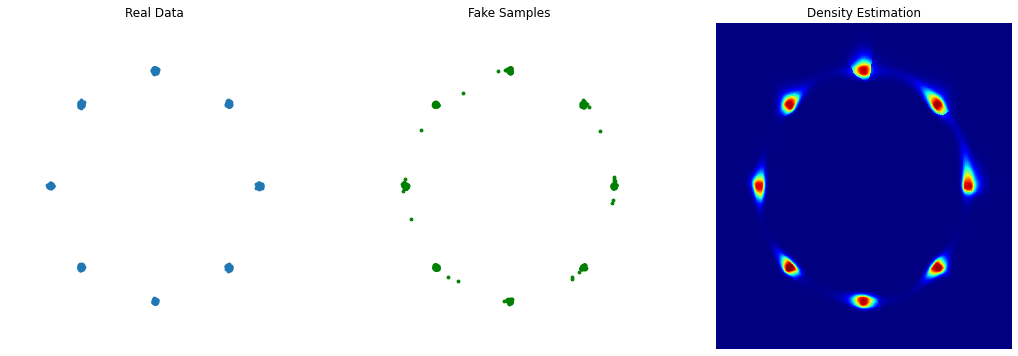

In [7]:
dataset = datasets[0]
beta_kl = chosen_hyperparmas[dataset]['b_kl']
beta_neg = chosen_hyperparmas[dataset]['b_neg']
beta_rec = chosen_hyperparmas[dataset]['b_rec']
if dataset == '8Gaussians':
    scale = 1
else:
    scale = 2
    
# train
model = train_soft_intro_vae_toy(z_dim=2, lr_e=lr, lr_d=lr, batch_size=batch_size, n_iter=num_iter, num_vae=2000, 
                             save_interval=5000, recon_loss_type="mse", beta_kl=beta_kl, beta_rec=beta_rec,
                             beta_neg=beta_neg, test_iter=5000, seed=seed, scale=scale,
                             device=device, dataset=dataset)

### <img src="https://img.icons8.com/nolan/64/more.png" style="height:50px;display:inline"> But Wait, There is More...
---
* Soft-IntroVAE Tutorials
    * [Soft-IntroVAE for Images](https://github.com/taldatech/soft-intro-vae-pytorch/blob/main/soft_intro_vae_tutorial/soft_intro_vae_image_code_tutorial.ipynb)
        * [Open in Colab](https://colab.research.google.com/github/taldatech/soft-intro-vae-pytorch/blob/main/soft_intro_vae_tutorial/soft_intro_vae_image_code_tutorial.ipynb)
    * [Bootstrap Soft-IntroVAE](https://github.com/taldatech/soft-intro-vae-pytorch/blob/main/soft_intro_vae_tutorial/soft_intro_vae_bootstrap_code_tutorial.ipynb)
        * [Open in Colab](https://colab.research.google.com/github/taldatech/soft-intro-vae-pytorch/blob/main/soft_intro_vae_tutorial/soft_intro_vae_bootstrap_code_tutorial.ipynb)
* General Tutorials (Jupyter Notebooks with code)
    * [CS236756 - Intro to Machine Learning](https://github.com/taldatech/cs236756-intro-to-ml)
    * [EE046202 - Unsupervised Learning and Data Analysis](https://github.com/taldatech/ee046202-unsupervised-learning-data-analysis)
    * [EE046746 - Computer Vision](https://github.com/taldatech/ee046746-computer-vision)

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
